In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import os
import re
import string
import contractions
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from indicnlp.tokenize import indic_tokenize
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim
import time
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from torch.amp import autocast, GradScaler

[nltk_data] Downloading package punkt to /home/sidan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print("Current Working Directory:", os.getcwd())
# Specify the new directory you want to change to
new_directory = "/mnt/c/Users/adils/Desktop"  # Replace with your target path
# Change the current working directory
os.chdir(new_directory)
# Print the new current working directory
print("New Working Directory:", os.getcwd())

: 

In [3]:
# Paths to data files
train_path = "/mnt/c/Users/adils/Desktop/FODL/ASS-3/team18_ta/team18_ta_train.csv"
test_path = "/mnt/c/Users/adils/Desktop/FODL/ASS-3/team18_ta/team18_ta_test.csv"
val_path = "/mnt/c/Users/adils/Desktop/FODL/ASS-3/team18_ta/team18_ta_valid.csv"
glove_path = "/mnt/c/Users/adils/Downloads/glove.6B.200d.txt/glove.6B.200d.txt"

In [4]:
def load_data(train_path, test_path, val_path):
    """Load and return dataframes from CSV files."""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    val_df = pd.read_csv(val_path)
    print(f"Data loaded successfully:")
    print(f"Training samples: {len(train_df)}")
    print(f"Testing samples: {len(test_df)}")
    print(f"Validation samples: {len(val_df)}")
    return train_df, test_df, val_df

In [5]:
def preprocess_english(text):
    text= contractions.fix(text)
    # Insert space before uppercase letters that follow lowercase letters
    text = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', text)
    # Lowercase
    text = text.lower()
    # Replace punctuations with space 
    for punct in string.punctuation:
        text = text.replace(punct, ' ')
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    tokens = text.split()
    return tokens

In [6]:
def preprocess_tamil(text):
    # Remove ASCII punctuations and special characters
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Remove numbers (both Western and Tamil)
    text = re.sub(r'\d+', '', text)  # Western digits
    text = re.sub(r'[\u0BE6-\u0BEF]+', '', text)  # Tamil digits
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize using indic-nlp-library
    tokens = indic_tokenize.trivial_tokenize(text)
    return tokens

In [7]:
def build_vocabulary(token_lists, max_vocab_size=60000):
    """Build vocabulary from token lists with a maximum size."""
    # Count word frequencies
    counter = Counter([token for tokens in token_lists for token in tokens])
    # Get the most common tokens up to max_vocab_size
    most_common_tokens = [token for token, _ in counter.most_common(max_vocab_size)]
    # Create vocabulary list with special tokens
    vocab = ['<pad>', '<unk>', '<sos>', '<eos>'] + most_common_tokens
    # Create token to index mapping
    token2idx = {token: idx for idx, token in enumerate(vocab)}
    return vocab, token2idx

In [8]:
# Load data
train_df, test_df, val_df = load_data(train_path, test_path, val_path)

Data loaded successfully:
Training samples: 70000
Testing samples: 10000
Validation samples: 20000


In [9]:
# Preprocess data
print("\nPreprocessing data...")
# Apply preprocessing to each sentence
train_df['source_tokens'] = train_df['source'].apply(preprocess_english)
train_df['target_tokens'] = train_df['target'].apply(preprocess_tamil)
if len(test_df) > 0:
    test_df['source_tokens'] = test_df['source'].apply(preprocess_english)
    test_df['target_tokens'] = test_df['target'].apply(preprocess_tamil)
if len(val_df) > 0:
    val_df['source_tokens'] = val_df['source'].apply(preprocess_english)
    val_df['target_tokens'] = val_df['target'].apply(preprocess_tamil)
print("\nPreprocessing done")


Preprocessing data...

Preprocessing done


In [10]:
# Print preprocessed examples
print("\nPreprocessed examples from training data:")
for i, row in train_df.head().iterrows():
    print(f"\nExample {i+1}:")
    print(f"English: {row['source']}")
    print(f"English tokens: {row['source_tokens']}")
    print(f"Tamil: {row['target']}")
    print(f"Tamil tokens: {row['target_tokens']}")


Preprocessed examples from training data:

Example 1:
English: Im not too worried.
English tokens: ['i', 'am', 'not', 'too', 'worried']
Tamil: நான் அதிகம் கவலைப்பட்டதேயில்லை.
Tamil tokens: ['நான்', 'அதிகம்', 'கவலைப்பட்டதேயில்லை']

Example 2:
English: Or does the Bible standard of sticking faithfully to ones mate still make good sense?
English tokens: ['or', 'does', 'the', 'bible', 'standard', 'of', 'sticking', 'faithfully', 'to', 'ones', 'mate', 'still', 'make', 'good', 'sense']
Tamil: அவர்களுடைய அன்பு தணிந்துபோனால் என்ன செய்வது?
Tamil tokens: ['அவர்களுடைய', 'அன்பு', 'தணிந்துபோனால்', 'என்ன', 'செய்வது']

Example 3:
English: At the time of testing, Rs.
English tokens: ['at', 'the', 'time', 'of', 'testing', 'rs']
Tamil: இந்த சோதனையின்போது, கணக்கில் வராத ரூ.
Tamil tokens: ['இந்த', 'சோதனையின்போது', 'கணக்கில்', 'வராத', 'ரூ']

Example 4:
English: Must apologise.
English tokens: ['must', 'apologise']
Tamil: மன்னிப்புக் கேட்டிருக்க வேண்டும்.
Tamil tokens: ['மன்னிப்புக்', 'கேட்டிருக்க', 'வேண்டு

In [11]:
# Build vocabularies
print("\nBuilding vocabularies...")
eng_vocab, eng_token2idx = build_vocabulary(train_df['source_tokens'])
tamil_vocab, tamil_token2idx = build_vocabulary(train_df['target_tokens'])
print(f"English vocabulary size: {len(eng_vocab)}")
print(f"Tamil vocabulary size: {len(tamil_vocab)}")


Building vocabularies...
English vocabulary size: 36937
Tamil vocabulary size: 60004


In [12]:
import torch
# Check if GPU is available and move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Successfully loading  on {device}")

Successfully loading  on cuda


In [13]:
eng_embeddings = np.load('eng_embeddings.npy')
tamil_embeddings = np.load('tamil_embeddings.npy')

In [14]:
def analyze_sequence_lengths(sequences, name):
    """Analyze and print sequence length statistics."""
    lengths = [len(seq) for seq in sequences]
    print(f"\n{name} sequence length statistics:")
    print(f"  Min length: {min(lengths)}")
    print(f"  Max length: {max(lengths)}")
    print(f"  Mean length: {np.mean(lengths):.2f}")
    print(f"  Median length: {np.median(lengths):.2f}")
    print(f"  95th percentile: {np.percentile(lengths, 95):.2f}")
    print(f"  99th percentile: {np.percentile(lengths, 99):.2f}")
    return lengths

def prepare_data(source_tokens, target_tokens, src_token2idx, tgt_token2idx, max_src_len=None, max_tgt_len=None):
    """
    Convert tokens to indices, add <sos>/<eos> tokens, and pad sequences.
    """
    # Determine max sequence lengths if not provided
    if max_src_len is None:
        src_lengths = analyze_sequence_lengths(source_tokens, "Source (English)")
        max_src_len = min(int(np.percentile(src_lengths, 99)), 100)
        print(f"  Using max source length: {max_src_len}")
    if max_tgt_len is None:
        tgt_lengths = analyze_sequence_lengths(target_tokens, "Target (Tamil)")
        max_tgt_len = min(int(np.percentile(tgt_lengths, 99)) + 2, 100)  # +2 for <sos> and <eos>
        print(f"  Using max target length: {max_tgt_len}")
    
    src_indices = []
    tgt_indices = []
    # Process each sample
    for src_tokens, tgt_tokens in zip(source_tokens, target_tokens):
        # Convert source tokens to indices and pad
        src_idx = [src_token2idx.get(token, src_token2idx['<unk>']) for token in src_tokens]
        src_idx = src_idx[:max_src_len]  # Truncate if too long
        src_idx = src_idx + [src_token2idx['<pad>']] * (max_src_len - len(src_idx))  # Pad
        # Convert target tokens to indices, add <sos> and <eos>, then pad
        tgt_idx = [tgt_token2idx.get(token, tgt_token2idx['<unk>']) for token in tgt_tokens]
        tgt_idx = tgt_idx[:max_tgt_len-2]  # Truncate if too long
        tgt_idx = [tgt_token2idx['<sos>']] + tgt_idx + [tgt_token2idx['<eos>']]  # Add <sos> and <eos>
        tgt_idx = tgt_idx + [tgt_token2idx['<pad>']] * (max_tgt_len - len(tgt_idx))  # Pad
        
        src_indices.append(src_idx)
        tgt_indices.append(tgt_idx)
    return np.array(src_indices), np.array(tgt_indices)

class TranslationDataset(Dataset):
    """PyTorch Dataset for machine translation."""
    def __init__(self, src_indices, tgt_indices):
        self.src_indices = torch.LongTensor(src_indices)
        self.tgt_indices = torch.LongTensor(tgt_indices)
        
    def __len__(self):
        return len(self.src_indices)
    
    def __getitem__(self, idx):
        return {
            'source': self.src_indices[idx],
            'target': self.tgt_indices[idx],
            'src_mask': self.src_indices[idx] != 0,  # Create mask for non-padding tokens
            'tgt_mask': self.tgt_indices[idx] != 0   # Create mask for non-padding tokens
        }

def create_dataloaders(train_df, val_df, test_df, src_token2idx, tgt_token2idx, 
                      max_src_len=None, max_tgt_len=None, batch_size=64):
    """Create DataLoaders for train, validation and test sets."""
    print("\nPreparing training data...")
    train_src, train_tgt = prepare_data(
        train_df['source_tokens'].tolist(), 
        train_df['target_tokens'].tolist(), 
        src_token2idx, tgt_token2idx, 
        max_src_len, max_tgt_len
    )
    # Use the same max lengths for all datasets
    max_src_len = train_src.shape[1]
    max_tgt_len = train_tgt.shape[1]
    print("\nPreparing validation data...")
    val_src, val_tgt = prepare_data(
        val_df['source_tokens'].tolist(), 
        val_df['target_tokens'].tolist(), 
        src_token2idx, tgt_token2idx, 
        max_src_len, max_tgt_len
    )
    print("\nPreparing test data...")
    test_src, test_tgt = prepare_data(
        test_df['source_tokens'].tolist(), 
        test_df['target_tokens'].tolist(), 
        src_token2idx, tgt_token2idx, 
        max_src_len, max_tgt_len
    )
    # Create datasets
    train_dataset = TranslationDataset(train_src, train_tgt)
    val_dataset = TranslationDataset(val_src, val_tgt)
    test_dataset = TranslationDataset(test_src, test_tgt)
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    print(f"\nCreated DataLoaders with batch size {batch_size}:")
    print(f"  Training batches: {len(train_loader)}")
    print(f"  Validation batches: {len(val_loader)}")
    print(f"  Testing batches: {len(test_loader)}")
    return train_loader, val_loader, test_loader, max_src_len, max_tgt_len

def verify_data_preparation(train_loader, eng_vocab, tamil_vocab):
    """Verify data preparation by examining samples from the DataLoader."""
    # Get a batch
    batch = next(iter(train_loader))
    src_batch = batch['source']
    tgt_batch = batch['target']
    print(f"\nVerification of data preparation:")
    print(f"  Source batch shape: {src_batch.shape}")
    print(f"  Target batch shape: {tgt_batch.shape}")
    # Look at the first example in the batch
    example_idx = 0
    src_indices = src_batch[example_idx].numpy()
    tgt_indices = tgt_batch[example_idx].numpy()
    # Get actual tokens from indices
    src_tokens = [eng_vocab[idx] for idx in src_indices]
    tgt_tokens = [tamil_vocab[idx] for idx in tgt_indices]
    print("\nExample from batch:")
    pad_end = src_tokens.index('<pad>') if '<pad>' in src_tokens else len(src_tokens)
    print(f"  Source tokens: {src_tokens[:pad_end]}")
    # Find the position of <eos> in target
    try:
        eos_pos = tgt_tokens.index('<eos>')
        tgt_content = tgt_tokens[1:eos_pos]  # Skip <sos> and stop at <eos>
        print(f"  Target tokens: ['<sos>'] + {tgt_content} + ['<eos>']")
    except ValueError:
        print(f"  Target tokens: {tgt_tokens}")
    
    # Check for <sos> and <eos> in target sequence
    sos_idx = tamil_vocab.index('<sos>')
    eos_idx = tamil_vocab.index('<eos>')
    print(f"\n  Target starts with <sos>: {tgt_indices[0] == sos_idx}")
    print(f"  Target contains <eos>: {eos_idx in tgt_indices}")
    return True

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, dropout=0.5, pre_trained_embeddings=None):
        """
        Encoder with single LSTM layer using pre-trained GloVe embeddings
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        # English embedding layer using GloVe
        self.embedding = nn.Embedding(input_dim, emb_dim)
        if pre_trained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pre_trained_embeddings))
            self.embedding.weight.requires_grad = True  # Allow fine-tuning
        # Single LSTM layer
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        # src = [batch_size, src_len]
        embedded = self.dropout(self.embedding(src))  # [batch_size, src_len, emb_dim]
        # Pass through LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell


class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        """
        Attention mechanism connecting encoder outputs to decoder
        """
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask=None):
        # hidden = [1, batch_size, dec_hidden_dim]
        # encoder_outputs = [batch_size, src_len, enc_hidden_dim]
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        # Repeat decoder hidden state src_len times
        hidden = hidden.permute(1, 0, 2)  # [batch_size, 1, dec_hidden_dim]
        hidden = hidden.repeat(1, src_len, 1)  # [batch_size, src_len, dec_hidden_dim]
        # Calculate energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # Get attention scores
        attention = self.v(energy).squeeze(2)  # [batch_size, src_len]
        # Apply mask for padding if provided
        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e4)
        
        # Get attention weights with softmax
        attention_weights = F.softmax(attention, dim=1)
        # Get context vector
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return attention_weights, context


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention, dropout=0.5, pre_trained_embeddings=None):
        """
        Decoder with attention and Tamil embeddings from IndicBERT
        """
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.attention = attention
        # Tamil embedding layer using IndicBERT
        self.embedding = nn.Embedding(output_dim, emb_dim)
        if pre_trained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pre_trained_embeddings))
            self.embedding.weight.requires_grad = True
        # LSTM with attention - input is embedding + context vector
        self.lstm = nn.LSTM(emb_dim + hidden_dim, hidden_dim, batch_first=True)
        # Output projection to Tamil vocabulary size
        self.fc_out = nn.Linear(emb_dim + hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell, encoder_outputs, src_mask=None):
        # input = [batch_size, 1]
        embedded = self.dropout(self.embedding(input))  # [batch_size, 1, emb_dim]
        # Calculate attention
        attention_weights, context = self.attention(hidden, encoder_outputs, src_mask)
        context = context.unsqueeze(1)  # [batch_size, 1, hidden_dim]
        # Concatenate embedding and context for LSTM input
        lstm_input = torch.cat((embedded, context), dim=2)
        # Get output from LSTM
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        # Prepare final projection input by combining all representations
        pred_input = torch.cat((embedded.squeeze(1), output.squeeze(1), context.squeeze(1)), dim=1)
        # Final projection to vocabulary size
        prediction = self.fc_out(pred_input)
        return prediction, hidden, cell, attention_weights


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        """
        Full sequence-to-sequence model with attention
        """
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    def create_mask(self, src):
        """Create mask for padded elements"""
        mask = (src != 0).type(torch.uint8)  # 0 is <pad> token index
        return mask
    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        # src = [batch_size, src_len]
        # tgt = [batch_size, tgt_len]
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.output_dim
        # Store predictions and attention weights
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, tgt_len, src.shape[1]).to(self.device)
        # Create source mask for attention
        src_mask = self.create_mask(src)
        # Encode the source sequence
        encoder_outputs, hidden, cell = self.encoder(src)
        # First input to decoder is <sos> token (should be at index 1 of tgt)
        input = tgt[:, 0].unsqueeze(1)
        for t in range(1, tgt_len):
            # Decode one token at a time
            output, hidden, cell, attention = self.decoder(
                input, hidden, cell, encoder_outputs, src_mask
            )
            # Store prediction and attention
            outputs[:, t, :] = output
            attentions[:, t, :] = attention
            # Teacher forcing - decide whether to use real target or predicted
            teacher_force = random.random() < teacher_forcing_ratio
            # Get next input token
            top1 = output.argmax(1)
            input = tgt[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)
        return outputs, attentions

In [16]:
def train_epoch_mixed_precision(model, train_loader, optimizer, criterion, device, scaler, accumulation_steps=8, clip_value=1.0):
    """Train for one epoch with mixed precision and gradient accumulation"""
    model.train()
    epoch_loss = 0
    batch_count = len(train_loader)
    # Using tqdm for progress bar
    progress_bar = tqdm(enumerate(train_loader), total=batch_count, desc="Training")
    # Zero gradients at the beginning
    optimizer.zero_grad(set_to_none=True)
    for i, batch in progress_bar:
        src = batch['source'].to(device)
        tgt = batch['target'].to(device)
        # Use autocast for mixed precision
        with autocast('cuda'):
            # Forward pass with teacher forcing
            output, _ = model(src, tgt, teacher_forcing_ratio=0.5)
            # Calculate loss
            output_dim = output.shape[-1]
            output = output[:, 1:].contiguous().view(-1, output_dim)
            tgt = tgt[:, 1:].contiguous().view(-1)
            # Normalize loss by accumulation steps - This is the key for gradient accumulation
            loss = criterion(output, tgt) / accumulation_steps
        # Scale loss and backward pass (accumulates gradients)
        scaler.scale(loss).backward()
        # Only step and zero grad every accumulation_steps or at the end of epoch
        if ((i + 1) % accumulation_steps == 0) or (i + 1 == batch_count):
            # Unscale before gradient clipping
            scaler.unscale_(optimizer)
            # Gradient clipping
            clip_grad_norm_(model.parameters(), clip_value)
            # Step with scaler and reset gradients
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)  # Faster than regular zero_grad
            # Print status periodically
            if (i + 4) % (accumulation_steps * 5) == 0:
                print(f"  Processed {i+4}/{batch_count} batches")
        # Track loss (use the unscaled loss for logging)
        epoch_loss += loss.item() * accumulation_steps
        # Update progress bar
        progress_bar.set_postfix(loss=f"{loss.item() * accumulation_steps:.4f}")
    return epoch_loss / batch_count

In [17]:
def evaluate(model, data_loader, criterion, device):
    """Evaluate model on data_loader - NO teacher forcing"""
    model.eval()
    epoch_loss = 0
    batch_count = len(data_loader)
    # Using tqdm for progress bar
    progress_bar = tqdm(data_loader, total=batch_count, desc="Evaluating")
    with torch.no_grad():
        for batch in progress_bar:
            src = batch['source'].to(device)
            tgt = batch['target'].to(device)
            # Forward pass without teacher forcing
            output, _ = model(src, tgt, teacher_forcing_ratio=0)
            # Calculate loss
            output_dim = output.shape[-1]
            output = output[:, 1:].contiguous().view(-1, output_dim)
            tgt = tgt[:, 1:].contiguous().view(-1)
            loss = criterion(output, tgt)
            epoch_loss += loss.item()
            # Update progress bar
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    return epoch_loss / batch_count

In [18]:
def calculate_bleu(model, data_loader, device, eng_vocab, tamil_vocab, pad_idx, eos_idx):
    """Calculate BLEU scores for different n-gram levels"""
    model.eval()
    all_references = []
    all_hypotheses = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Calculating BLEU"):
            src = batch['source'].to(device)
            tgt = batch['target'].to(device)
            # Forward pass without teacher forcing
            output, _ = model(src, tgt, 0)
            # Get predicted tokens
            pred = output.argmax(dim=-1)
            # Convert predictions to tokens and references to tokens
            for i in range(src.size(0)):
                reference = []
                for token in tgt[i, 1:]:  # Skip <sos>
                    if token.item() == eos_idx:
                        break
                    if token.item() != pad_idx:
                        reference.append(token.item())
                hypothesis = []
                for token in pred[i, 1:]:  # Skip first prediction
                    if token.item() == eos_idx:
                        break
                    if token.item() != pad_idx:
                        hypothesis.append(token.item())
                all_references.append([reference])
                all_hypotheses.append(hypothesis)
    # Calculate BLEU scores for different n-gram levels
    smooth = SmoothingFunction().method1
    bleu_scores = {}
    for k in range(1, 5):
        weights = tuple([1/k] * k) 
        score = corpus_bleu(all_references, all_hypotheses, weights=weights, smoothing_function=smooth)
        bleu_scores[f'bleu-{k}'] = score
    return bleu_scores

In [19]:
def train_model(model, train_loader, val_loader, test_loader, eng_vocab, tamil_vocab, pad_idx, eos_idx, device, 
               n_epochs=10, learning_rate=0.001, patience=5, clip_value=1.0, accumulation_steps=8):
    """Complete training loop with mixed precision and gradient accumulation"""
    # Clear GPU memory
    torch.cuda.empty_cache()
    gc.collect()
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    # Move model to device
    model.to(device)
    # Initialize AMP GradScaler for mixed precision
    scaler = GradScaler('cuda')
    # Loss function: CrossEntropyLoss ignoring padding tokens
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    # Optimizer: Adam with learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model = None
    # Record metrics
    train_losses = []
    val_losses = []
    bleu_scores = []
    
    print(f"Starting training with mixed precision and gradient accumulation for {n_epochs} epochs...")
    print(f"Using device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"Accumulation steps: {accumulation_steps} (effective batch size: {accumulation_steps}x)")
    
    for epoch in range(n_epochs):
        start_time = time.time()
        # Train one epoch with mixed precision and gradient accumulation
        train_loss = train_epoch_mixed_precision(
            model, train_loader, optimizer, criterion, device, scaler, 
            accumulation_steps=accumulation_steps, clip_value=clip_value
        )
        train_losses.append(train_loss)
        # Evaluate on validation set
        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        # Learning rate scheduler step
        scheduler.step(val_loss)
        # Calculate BLEU scores (periodically to save time)
        if epoch % 1 == 0:  # Calculate every epoch
            bleu = calculate_bleu(model, val_loader, device, eng_vocab, tamil_vocab, pad_idx, eos_idx)
            bleu_scores.append(bleu)
        else:
            bleu = {'bleu-1': 0, 'bleu-2': 0, 'bleu-3': 0, 'bleu-4': 0}
        # Calculate elapsed time
        elapsed_time = time.time() - start_time
        epoch_mins, epoch_secs = divmod(elapsed_time, 60)
        # Check for early stopping and save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the best model state
            best_model = {key: value.cpu().clone() for key, value in model.state_dict().items()}
            print(f"model saved with validation loss: {val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            
        # Print epoch information
        print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.0f}s")
        print(f"\tTrain Loss: {train_loss:.4f}")
        print(f"\tVal. Loss: {val_loss:.4f}")
        # Print BLEU scores
        for k, score in bleu.items():
            print(f"\t{k.upper()}: {score:.4f}")
        # Check for early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch+1} epochs!")
            model.load_state_dict(best_model)
            for param in best_model:
                best_model[param] = best_model[param].to(device)
            break
        # Clear GPU memory between epochs if needed
        if torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated() > 0.7:
            torch.cuda.empty_cache()
            gc.collect()
    # Load best model at the end
    if best_model is not None:
        # Copy best model back to device
        for param in best_model:
            best_model[param] = best_model[param].to(device)
        model.load_state_dict(best_model)
        print("Loaded best model from training")
    
    return model, train_losses, val_losses, bleu_scores

In [ ]:
def generate_examples(model, data_loader, eng_vocab, tamil_vocab, pad_idx, sos_idx, eos_idx, device, num_examples=5):
    """Generate translations for sample examples"""
    model.eval()
    examples = []
    with torch.no_grad():
        # Get a batch
        batch = next(iter(data_loader))
        src = batch['source'][:num_examples].to(device)
        tgt = batch['target'][:num_examples].to(device)
        # Generate translations
        output, _ = model(src, tgt, teacher_forcing_ratio=0)
        predictions = output.argmax(dim=2)
        # Convert to readable text
        for i in range(num_examples):
            # Source text
            src_tokens = [eng_vocab[idx.item()] for idx in src[i] if idx.item() != pad_idx]
            src_text = ' '.join(src_tokens)
            
            # Target text
            tgt_tokens = []
            for idx in tgt[i, 1:]:  # Skip <sos>
                if idx.item() == eos_idx:
                    break
                if idx.item() != pad_idx:
                    tgt_tokens.append(tamil_vocab[idx.item()])
            tgt_text = ' '.join(tgt_tokens)
            # Predicted text
            pred_tokens = []
            for idx in predictions[i, 1:]:  # Skip first token
                if idx.item() == eos_idx:
                    break
                if idx.item() != pad_idx:
                    pred_tokens.append(tamil_vocab[idx.item()])
            pred_text = ' '.join(pred_tokens)
            
            examples.append({
                'source': src_text,
                'reference': tgt_text,
                'prediction': pred_text
            })
    return examples

In [38]:
def generate_examples_random(model, data_loader, eng_vocab, tamil_vocab, pad_idx, sos_idx, eos_idx, device, num_examples=5):
    """Generate translations for random sample examples"""
    model.eval()
    examples = []
    with torch.no_grad():
        # Get a batch
        batch = next(iter(data_loader))
        src = batch['source']
        tgt = batch['target']
        batch_size = src.size(0)
        # Randomly select indices
        indices = random.sample(range(batch_size), min(num_examples, batch_size))
        src = src[indices].to(device)
        tgt = tgt[indices].to(device)
        # Generate translations
        output, _ = model(src, tgt, teacher_forcing_ratio=0)
        predictions = output.argmax(dim=2)
        # Convert to readable text
        for i in range(len(indices)):
            # Source text
            src_tokens = [eng_vocab[idx.item()] for idx in src[i] if idx.item() != pad_idx]
            src_text = ' '.join(src_tokens)
            # Target text
            tgt_tokens = []
            for idx in tgt[i, 1:]:  # Skip <sos>
                if idx.item() == eos_idx:
                    break
                if idx.item() != pad_idx:
                    tgt_tokens.append(tamil_vocab[idx.item()])
            tgt_text = ' '.join(tgt_tokens)
            # Predicted text
            pred_tokens = []
            for idx in predictions[i, 1:]:  # Skip first token
                if idx.item() == eos_idx:
                    break
                if idx.item() != pad_idx:
                    pred_tokens.append(tamil_vocab[idx.item()])
            pred_text = ' '.join(pred_tokens)
            examples.append({
                'source': src_text,
                'reference': tgt_text,
                'prediction': pred_text
            })
    return examples


In [21]:


def plot_metrics(train_losses, val_losses, bleu_scores):
    epochs = range(1, len(train_losses) + 1)
    fig, ax1 = plt.subplots(figsize=(10, 6))
    # Plot train and validation losses
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper left')
    plt.title('Training and Validation Losses ')
    plt.show()
    # Create a second y-axis for BLEU scores
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bleu_4_scores = [bleu['bleu-4'] for bleu in bleu_scores]
    ax1.plot(epochs, bleu_4_scores, 'g--', label='BLEU-4 Score')
    ax1.set_ylabel('BLEU-4 Score')
    ax1.legend(loc='upper right')
    plt.title(' BLEU-4 Score')
    plt.show()
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bleu_3_scores = [bleu['bleu-3'] for bleu in bleu_scores]
    ax1.plot(epochs, bleu_3_scores, 'g--', label='BLEU-3 Score')
    ax1.set_ylabel('BLEU-3 Score')
    ax1.legend(loc='upper right')
    plt.title(' BLEU-3 Score')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(10, 6))
    bleu_2_scores = [bleu['bleu-2'] for bleu in bleu_scores]
    ax1.plot(epochs, bleu_3_scores, 'g--', label='BLEU-2 Score')
    ax1.set_ylabel('BLEU-2 Score')
    ax1.legend(loc='upper right')
    plt.title(' BLEU-2 Score')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(10, 6))
    bleu_1_scores = [bleu['bleu-1'] for bleu in bleu_scores]
    ax1.plot(epochs, bleu_1_scores, 'g--', label='BLEU-1 Score')
    ax1.set_ylabel('BLEU-1 Score')
    ax1.legend(loc='upper right')
    plt.title(' BLEU-1 Score')
    plt.show()

In [22]:
# Define batch size and sequence length limits
batch_size = 64
max_src_len = None  # Will be determined from data analysis
max_tgt_len = None  # Will be determined from data analysis
# Create dataloaders
train_loader, val_loader, test_loader, final_src_len, final_tgt_len = create_dataloaders(
    train_df, val_df, test_df,
    eng_token2idx, tamil_token2idx,
    max_src_len, max_tgt_len,
    batch_size
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Preparing training data...

Source (English) sequence length statistics:
  Min length: 1
  Max length: 415
  Mean length: 11.26
  Median length: 8.00
  95th percentile: 31.00
  99th percentile: 47.00
  Using max source length: 47

Target (Tamil) sequence length statistics:
  Min length: 1
  Max length: 274
  Mean length: 8.17
  Median length: 6.00
  95th percentile: 21.00
  99th percentile: 34.00
  Using max target length: 36

Preparing validation data...

Preparing test data...

Created DataLoaders with batch size 64:
  Training batches: 1094
  Validation batches: 313
  Testing batches: 157
Using device: cuda


In [23]:
# Clear any existing allocations
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
# Create the model components
hidden_dim = 384  # Good balance for RTX 2060
# Set training parameters
n_epochs = 50
learning_rate = 0.0001
patience = 4
clip_value = 1.0
accumulation_steps = 4  # Effective batch size will be 8x actual batch size
dropout = 0.3

# Create encoder
encoder = Encoder(
    input_dim=len(eng_vocab),
    emb_dim=eng_embeddings.shape[1],
    hidden_dim=hidden_dim,
    dropout=dropout,  # Reduced dropout for faster training
    pre_trained_embeddings=eng_embeddings
)

# Create attention mechanism
attention = Attention(
    enc_hidden_dim=hidden_dim,
    dec_hidden_dim=hidden_dim
)

# Create decoder
decoder = Decoder(
    output_dim=len(tamil_vocab),
    emb_dim=tamil_embeddings.shape[1],
    hidden_dim=hidden_dim,
    attention=attention,
    dropout=dropout,
    pre_trained_embeddings=tamil_embeddings
)

# Create full model
model = Seq2Seq(encoder, decoder, device)

# Special token indices
pad_idx = tamil_token2idx['<pad>']
sos_idx = tamil_token2idx['<sos>']
eos_idx = tamil_token2idx['<eos>']

# Train model
trained_model, train_losses, val_losses, bleu_scores = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader, 
    test_loader=test_loader,
    eng_vocab=eng_vocab,
    tamil_vocab=tamil_vocab,
    pad_idx=pad_idx,
    eos_idx=eos_idx,
    device=device,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    patience=patience,
    clip_value=clip_value,
    accumulation_steps=accumulation_steps
)    
# Save the trained model
torch.save(trained_model.state_dict(), 'eng_tamil_translation_model.pt')
print("\nModel saved successfully!")

# Final cleanup
torch.cuda.empty_cache()
gc.collect()

GPU memory allocated: 0.00 GB
GPU memory cached: 0.00 GB


/home/sidan/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training with mixed precision and gradient accumulation for 50 epochs...
Using device: cuda
Model parameters: 149,254,764
Accumulation steps: 4 (effective batch size: 4x)


Calculating BLEU: 100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


model saved with validation loss: 7.0777
Epoch: 01 | Time: 21.0m 34s
	Train Loss: 8.4013
	Val. Loss: 7.0777
	BLEU-1: 0.1864
	BLEU-2: 0.0916
	BLEU-3: 0.0476
	BLEU-4: 0.0266


Calculating BLEU: 100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


model saved with validation loss: 6.9344
Epoch: 02 | Time: 21.0m 38s
	Train Loss: 7.6979
	Val. Loss: 6.9344
	BLEU-1: 0.1826
	BLEU-2: 0.0911
	BLEU-3: 0.0478
	BLEU-4: 0.0269


Calculating BLEU: 100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


model saved with validation loss: 6.7948
Epoch: 03 | Time: 21.0m 12s
	Train Loss: 7.5073
	Val. Loss: 6.7948
	BLEU-1: 0.1896
	BLEU-2: 0.0945
	BLEU-3: 0.0493
	BLEU-4: 0.0276


Calculating BLEU: 100%|██████████| 313/313 [02:57<00:00,  1.76it/s]


model saved with validation loss: 6.6836
Epoch: 04 | Time: 22.0m 33s
	Train Loss: 7.3197
	Val. Loss: 6.6836
	BLEU-1: 0.1918
	BLEU-2: 0.0958
	BLEU-3: 0.0498
	BLEU-4: 0.0279


Calculating BLEU: 100%|██████████| 313/313 [02:53<00:00,  1.81it/s]


model saved with validation loss: 6.5718
Epoch: 05 | Time: 22.0m 18s
	Train Loss: 7.1394
	Val. Loss: 6.5718
	BLEU-1: 0.1907
	BLEU-2: 0.0949
	BLEU-3: 0.0494
	BLEU-4: 0.0277


Calculating BLEU: 100%|██████████| 313/313 [03:02<00:00,  1.71it/s]


model saved with validation loss: 6.4855
Epoch: 06 | Time: 22.0m 15s
	Train Loss: 6.9701
	Val. Loss: 6.4855
	BLEU-1: 0.1978
	BLEU-2: 0.0978
	BLEU-3: 0.0505
	BLEU-4: 0.0281


Calculating BLEU: 100%|██████████| 313/313 [02:55<00:00,  1.78it/s]


model saved with validation loss: 6.4055
Epoch: 07 | Time: 22.0m 27s
	Train Loss: 6.8191
	Val. Loss: 6.4055
	BLEU-1: 0.1971
	BLEU-2: 0.0978
	BLEU-3: 0.0506
	BLEU-4: 0.0282


Calculating BLEU: 100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


model saved with validation loss: 6.3450
Epoch: 08 | Time: 22.0m 29s
	Train Loss: 6.6839
	Val. Loss: 6.3450
	BLEU-1: 0.2009
	BLEU-2: 0.0997
	BLEU-3: 0.0516
	BLEU-4: 0.0287


Calculating BLEU: 100%|██████████| 313/313 [03:00<00:00,  1.74it/s]


model saved with validation loss: 6.2943
Epoch: 09 | Time: 22.0m 24s
	Train Loss: 6.5571
	Val. Loss: 6.2943
	BLEU-1: 0.2024
	BLEU-2: 0.1003
	BLEU-3: 0.0518
	BLEU-4: 0.0287


Calculating BLEU: 100%|██████████| 313/313 [02:46<00:00,  1.88it/s]


model saved with validation loss: 6.2498
Epoch: 10 | Time: 21.0m 18s
	Train Loss: 6.4420
	Val. Loss: 6.2498
	BLEU-1: 0.2032
	BLEU-2: 0.1009
	BLEU-3: 0.0521
	BLEU-4: 0.0289


Calculating BLEU: 100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


model saved with validation loss: 6.2117
Epoch: 11 | Time: 21.0m 25s
	Train Loss: 6.3288
	Val. Loss: 6.2117
	BLEU-1: 0.2044
	BLEU-2: 0.1017
	BLEU-3: 0.0527
	BLEU-4: 0.0292


Calculating BLEU: 100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


model saved with validation loss: 6.1767
Epoch: 12 | Time: 21.0m 22s
	Train Loss: 6.2293
	Val. Loss: 6.1767
	BLEU-1: 0.2065
	BLEU-2: 0.1031
	BLEU-3: 0.0532
	BLEU-4: 0.0294


Calculating BLEU: 100%|██████████| 313/313 [02:46<00:00,  1.88it/s]


model saved with validation loss: 6.1502
Epoch: 13 | Time: 21.0m 12s
	Train Loss: 6.1302
	Val. Loss: 6.1502
	BLEU-1: 0.2063
	BLEU-2: 0.1030
	BLEU-3: 0.0533
	BLEU-4: 0.0297


Calculating BLEU: 100%|██████████| 313/313 [02:46<00:00,  1.88it/s]


model saved with validation loss: 6.1201
Epoch: 14 | Time: 21.0m 20s
	Train Loss: 6.0311
	Val. Loss: 6.1201
	BLEU-1: 0.2087
	BLEU-2: 0.1039
	BLEU-3: 0.0534
	BLEU-4: 0.0295


Calculating BLEU: 100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


model saved with validation loss: 6.0931
Epoch: 15 | Time: 21.0m 8s
	Train Loss: 5.9442
	Val. Loss: 6.0931
	BLEU-1: 0.2088
	BLEU-2: 0.1045
	BLEU-3: 0.0542
	BLEU-4: 0.0300


Calculating BLEU: 100%|██████████| 313/313 [02:47<00:00,  1.87it/s]


model saved with validation loss: 6.0796
Epoch: 16 | Time: 21.0m 13s
	Train Loss: 5.8537
	Val. Loss: 6.0796
	BLEU-1: 0.2110
	BLEU-2: 0.1059
	BLEU-3: 0.0547
	BLEU-4: 0.0303


Calculating BLEU: 100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


model saved with validation loss: 6.0586
Epoch: 17 | Time: 21.0m 3s
	Train Loss: 5.7736
	Val. Loss: 6.0586
	BLEU-1: 0.2118
	BLEU-2: 0.1063
	BLEU-3: 0.0549
	BLEU-4: 0.0305


Calculating BLEU: 100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


model saved with validation loss: 6.0332
Epoch: 18 | Time: 21.0m 5s
	Train Loss: 5.6912
	Val. Loss: 6.0332
	BLEU-1: 0.2109
	BLEU-2: 0.1061
	BLEU-3: 0.0551
	BLEU-4: 0.0306


Calculating BLEU: 100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


model saved with validation loss: 6.0287
Epoch: 19 | Time: 21.0m 13s
	Train Loss: 5.6117
	Val. Loss: 6.0287
	BLEU-1: 0.2129
	BLEU-2: 0.1070
	BLEU-3: 0.0554
	BLEU-4: 0.0307


Calculating BLEU: 100%|██████████| 313/313 [02:39<00:00,  1.96it/s]


model saved with validation loss: 6.0097
Epoch: 20 | Time: 21.0m 3s
	Train Loss: 5.5311
	Val. Loss: 6.0097
	BLEU-1: 0.2129
	BLEU-2: 0.1076
	BLEU-3: 0.0559
	BLEU-4: 0.0311


Calculating BLEU: 100%|██████████| 313/313 [02:40<00:00,  1.95it/s]


model saved with validation loss: 5.9982
Epoch: 21 | Time: 21.0m 1s
	Train Loss: 5.4625
	Val. Loss: 5.9982
	BLEU-1: 0.2140
	BLEU-2: 0.1080
	BLEU-3: 0.0560
	BLEU-4: 0.0311


Calculating BLEU: 100%|██████████| 313/313 [02:46<00:00,  1.88it/s]


model saved with validation loss: 5.9922
Epoch: 22 | Time: 21.0m 16s
	Train Loss: 5.3865
	Val. Loss: 5.9922
	BLEU-1: 0.2167
	BLEU-2: 0.1096
	BLEU-3: 0.0571
	BLEU-4: 0.0317


Calculating BLEU: 100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


model saved with validation loss: 5.9802
Epoch: 23 | Time: 21.0m 11s
	Train Loss: 5.3077
	Val. Loss: 5.9802
	BLEU-1: 0.2178
	BLEU-2: 0.1099
	BLEU-3: 0.0572
	BLEU-4: 0.0318


Calculating BLEU: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


model saved with validation loss: 5.9732
Epoch: 24 | Time: 21.0m 12s
	Train Loss: 5.2401
	Val. Loss: 5.9732
	BLEU-1: 0.2198
	BLEU-2: 0.1109
	BLEU-3: 0.0578
	BLEU-4: 0.0322


Calculating BLEU: 100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


model saved with validation loss: 5.9684
Epoch: 25 | Time: 21.0m 17s
	Train Loss: 5.1727
	Val. Loss: 5.9684
	BLEU-1: 0.2186
	BLEU-2: 0.1111
	BLEU-3: 0.0582
	BLEU-4: 0.0326


Calculating BLEU: 100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


model saved with validation loss: 5.9572
Epoch: 26 | Time: 21.0m 5s
	Train Loss: 5.1046
	Val. Loss: 5.9572
	BLEU-1: 0.2183
	BLEU-2: 0.1109
	BLEU-3: 0.0579
	BLEU-4: 0.0322


Calculating BLEU: 100%|██████████| 313/313 [02:47<00:00,  1.87it/s]


model saved with validation loss: 5.9524
Epoch: 27 | Time: 21.0m 9s
	Train Loss: 5.0362
	Val. Loss: 5.9524
	BLEU-1: 0.2189
	BLEU-2: 0.1112
	BLEU-3: 0.0584
	BLEU-4: 0.0327


Calculating BLEU: 100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


model saved with validation loss: 5.9460
Epoch: 28 | Time: 21.0m 9s
	Train Loss: 4.9705
	Val. Loss: 5.9460
	BLEU-1: 0.2204
	BLEU-2: 0.1121
	BLEU-3: 0.0585
	BLEU-4: 0.0324


Calculating BLEU: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


model saved with validation loss: 5.9419
Epoch: 29 | Time: 21.0m 17s
	Train Loss: 4.9067
	Val. Loss: 5.9419
	BLEU-1: 0.2221
	BLEU-2: 0.1130
	BLEU-3: 0.0590
	BLEU-4: 0.0328


Calculating BLEU: 100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


model saved with validation loss: 5.9356
Epoch: 30 | Time: 21.0m 15s
	Train Loss: 4.8353
	Val. Loss: 5.9356
	BLEU-1: 0.2241
	BLEU-2: 0.1136
	BLEU-3: 0.0592
	BLEU-4: 0.0328


Calculating BLEU: 100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


model saved with validation loss: 5.9319
Epoch: 31 | Time: 21.0m 23s
	Train Loss: 4.7754
	Val. Loss: 5.9319
	BLEU-1: 0.2242
	BLEU-2: 0.1136
	BLEU-3: 0.0595
	BLEU-4: 0.0331


Calculating BLEU: 100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


Epoch: 32 | Time: 21.0m 21s
	Train Loss: 4.7145
	Val. Loss: 5.9319
	BLEU-1: 0.2224
	BLEU-2: 0.1134
	BLEU-3: 0.0595
	BLEU-4: 0.0332


Calculating BLEU: 100%|██████████| 313/313 [02:46<00:00,  1.87it/s]


model saved with validation loss: 5.9290
Epoch: 33 | Time: 21.0m 27s
	Train Loss: 4.6552
	Val. Loss: 5.9290
	BLEU-1: 0.2227
	BLEU-2: 0.1137
	BLEU-3: 0.0597
	BLEU-4: 0.0333


Calculating BLEU: 100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


Epoch: 34 | Time: 21.0m 7s
	Train Loss: 4.5881
	Val. Loss: 5.9325
	BLEU-1: 0.2253
	BLEU-2: 0.1147
	BLEU-3: 0.0603
	BLEU-4: 0.0338


Calculating BLEU: 100%|██████████| 313/313 [02:42<00:00,  1.92it/s]


Epoch: 35 | Time: 21.0m 5s
	Train Loss: 4.5296
	Val. Loss: 5.9294
	BLEU-1: 0.2257
	BLEU-2: 0.1153
	BLEU-3: 0.0608
	BLEU-4: 0.0342


Calculating BLEU: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


Epoch: 36 | Time: 21.0m 25s
	Train Loss: 4.4676
	Val. Loss: 5.9297
	BLEU-1: 0.2266
	BLEU-2: 0.1154
	BLEU-3: 0.0607
	BLEU-4: 0.0341


Calculating BLEU: 100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


model saved with validation loss: 5.9191
Epoch: 37 | Time: 21.0m 16s
	Train Loss: 4.3859
	Val. Loss: 5.9191
	BLEU-1: 0.2271
	BLEU-2: 0.1159
	BLEU-3: 0.0609
	BLEU-4: 0.0341


Calculating BLEU: 100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


Epoch: 38 | Time: 21.0m 16s
	Train Loss: 4.3465
	Val. Loss: 5.9248
	BLEU-1: 0.2273
	BLEU-2: 0.1160
	BLEU-3: 0.0609
	BLEU-4: 0.0341


Calculating BLEU: 100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


Epoch: 39 | Time: 21.0m 28s
	Train Loss: 4.3144
	Val. Loss: 5.9234
	BLEU-1: 0.2277
	BLEU-2: 0.1160
	BLEU-3: 0.0610
	BLEU-4: 0.0341


Calculating BLEU: 100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


Epoch: 40 | Time: 21.0m 23s
	Train Loss: 4.2793
	Val. Loss: 5.9231
	BLEU-1: 0.2271
	BLEU-2: 0.1158
	BLEU-3: 0.0610
	BLEU-4: 0.0344


Calculating BLEU: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


Epoch: 41 | Time: 21.0m 36s
	Train Loss: 4.2453
	Val. Loss: 5.9225
	BLEU-1: 0.2274
	BLEU-2: 0.1160
	BLEU-3: 0.0610
	BLEU-4: 0.0343
Early stopping after 41 epochs!
Loaded best model from training

Model saved successfully!


24

In [39]:
print("\nTraining Examples:")
train_examples = generate_examples_random(
    trained_model, train_loader, eng_vocab, tamil_vocab, 
    pad_idx, sos_idx, eos_idx, device, num_examples = 60
)

for i, ex in enumerate(train_examples):
    print(f"\nExample {i+1}:")
    print(f"Source: {ex['source']}")
    print(f"Reference: {ex['reference']}")
    print(f"Prediction: {ex['prediction']}")


Training Examples:

Example 1:
Source: irish wolfhound
Reference: உங்கள் வீடு பாதுகாப்பாக இருக்க
Prediction: <unk> <unk>

Example 2:
Source: crore has been made
Reference: கோடி பரிசுத்தொகை கிடைத்தது
Prediction: கோடி கோடி

Example 3:
Source: excuse me
Reference: எங்களை மன்னிச்சிருங்க
Prediction: <unk> <unk>

Example 4:
Source: congress mla arrested
Reference: காங்கிரஸ் பிரமுகர் கைது
Prediction: திமுக தலைவர்

Example 5:
Source: parents what does your example teach
Reference: “ நீங்கள் பிரியமான பிள்ளைகளைப்போலத் தேவனைப் பின்பற்றுகிறவர்களாகி
Prediction: உங்கள் <unk> <unk>

Example 6:
Source: the resource such as home or work allowing to distinguish among several terminals registered to the same account leave empty if you do not know what it is
Reference: ஒரே கணக்கில் பதிவுசெய்யப்பட்டுள்ள பல சாதனமுனகளை வேறுபடுத்தியறிய உதவும் வளம் வீடு அல்லது பணி போன்று இது என்ன என்று தெரியாவிட்டால் காலியாக விடவும்
Prediction: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk

In [40]:
print("\nTraining Examples:")
train_examples = generate_examples_random(
    trained_model, train_loader, eng_vocab, tamil_vocab, 
    pad_idx, sos_idx, eos_idx, device, num_examples = 60
)

for i, ex in enumerate(train_examples):
    print(f"\nExample {i+1}:")
    print(f"Source: {ex['source']}")
    print(f"Reference: {ex['reference']}")
    print(f"Prediction: {ex['prediction']}")


Training Examples:

Example 1:
Source: eat what you want
Reference: <unk> சாப்பிட்டு விட வேண்டியது
Prediction: <unk> <unk>

Example 2:
Source: crore is available
Reference: ஆயிரம் நிதி கிடைக்கிறது
Prediction: கோடி <unk>

Example 3:
Source: there has not been any concrete information in this regard
Reference: இது குறித்து விரிவான தகவல் வெளியிடப்படவில்லை
Prediction: இது தொடர்பாக எந்த எந்த தகவலும் இல்லை

Example 4:
Source: few major decisions were also taken
Reference: முக்கிய தீர்மானங்களும் அங்கு நிறைவேற்றப்பட்டன
Prediction: பல பல <unk> <unk>

Example 5:
Source: msmes besides contributing to the balanced regional development are in a unique position to become global players attracting partners with technology and funds
Reference: குறு சிறு மற்றும் நடுத்தரத் தொழில் நிறுவனங்கள் தங்கள் பகுதியின் சமச்சீர் வளர்ச்சிக்கு உறுதுணை செய்வதுடன் <unk> தனித்தன்மை பெற்று நிதி மற்றும் தொழில்நுட்பம் உடைய பங்குதாரர்களை ஈர்க்கும் வகையில் அமைந்துள்ளன
Prediction: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <u

In [27]:
print("\nTraining Examples:")
train_examples = generate_examples(
    trained_model, train_loader, eng_vocab, tamil_vocab, 
    pad_idx, sos_idx, eos_idx, device, num_examples = 60
)

for i, ex in enumerate(train_examples):
    print(f"\nExample {i+1}:")
    print(f"Source: {ex['source']}")
    print(f"Reference: {ex['reference']}")
    print(f"Prediction: {ex['prediction']}")


Training Examples:

Example 1:
Source: to a question on whether he was being made the tourism ambassador for malaysia rajinkanth said it was not true
Reference: மலேசியாவின் சுற்றுலாத் தூதராக இருக்கும்படி <unk> என்ற கேள்விக்கு அது உண்மையல்ல என்று ரஜினி பதிலளித்தார்
Prediction: இந்த <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Example 2:
Source: let us see what happens in the future
Reference: எதிர்கால விடயங்கள் தொடர்பில் பொறுத்திருந்து பார்ப்போம்
Prediction: <unk> <unk> <unk> பார்ப்போம்

Example 3:
Source: i fainted
Reference: நொடிந்து போனேன்
Prediction: <unk> <unk>

Example 4:
Source: mlas to be inducted as cabinet ministers in karnataka
Reference: கர்நாடக அமைச்சரவையில் அமைச்சர்கள் பதவி <unk>
Prediction: இந்த <unk> <unk> <unk> <unk>

Example 5:
Source: let us help you
Reference: உதவி தருவோம்
Prediction: <unk> <unk>

Example 6:
Source: dispensation of justice
Reference: <unk> நீதி
Prediction: <unk> <unk>

Example 7:
Source: apollos aristarchus
Reference: <unk>
Pre

In [35]:
print("\nTest Examples:")
test_examples = generate_examples(
    trained_model, test_loader, eng_vocab, tamil_vocab, 
    pad_idx, sos_idx, eos_idx, device, num_examples=60
)

for i, ex in enumerate(test_examples):
    print(f"\nExample {i+1}:")
    print(f"Source: {ex['source']}")
    print(f"Reference: {ex['reference']}")
    print(f"Prediction: {ex['prediction']}")


Test Examples:

Example 1:
Source: to indias relations with the host countries
Reference: அண்டை நாடுகளுடன் இந்தியாவின் உறவு எப்படி
Prediction: இந்தியாவும் அமெரிக்காவும் <unk> உறவு

Example 2:
Source: each person has their unique talent
Reference: ஒவ்வொரு <unk> ஒவ்வொரு திறமை
Prediction: ஒவ்வொரு <unk> <unk> <unk>

Example 3:
Source: the meeting is expected to take place in the coming week
Reference: எதிர்வரும் வாரங்களில் இந்த சந்திப்பு நடைபெறும் எனக் குறிப்பிடப்படுகிறது
Prediction: அடுத்த வாரம் அடுத்த வாரம் அடுத்த வாரம் <unk>

Example 4:
Source: pradhan mantri gram sadak yojana pmgsy is being implemented across the country particularly in states having historical deficit of rural roads assam west bengal odisha bihar jharkhand madhya pradesh chhattisgarh rajasthan himachal pradesh j k and <unk> as never before the pace of construction of pmgsy roads
Reference: பிரதம மந்திரி கிராமச் சாலைத் திட்டம் <unk> நாடுமுழுவதும் குறிப்பாக வரலாற்று ரீதியாக <unk> சாலை வசதிகள் அதிகம் இல்லாத மாநிலங்களில்

In [28]:
# Generate example translations from test data
print("\nTest Examples:")
test_examples = generate_examples(
    trained_model, test_loader, eng_vocab, tamil_vocab, 
    pad_idx, sos_idx, eos_idx, device, num_examples=60
)

for i, ex in enumerate(test_examples):
    print(f"\nExample {i+1}:")
    print(f"Source: {ex['source']}")
    print(f"Reference: {ex['reference']}")
    print(f"Prediction: {ex['prediction']}")


Test Examples:

Example 1:
Source: to indias relations with the host countries
Reference: அண்டை நாடுகளுடன் இந்தியாவின் உறவு எப்படி
Prediction: இந்தியாவும் அமெரிக்காவும் <unk> உறவு

Example 2:
Source: each person has their unique talent
Reference: ஒவ்வொரு <unk> ஒவ்வொரு திறமை
Prediction: ஒவ்வொரு <unk> <unk> <unk>

Example 3:
Source: the meeting is expected to take place in the coming week
Reference: எதிர்வரும் வாரங்களில் இந்த சந்திப்பு நடைபெறும் எனக் குறிப்பிடப்படுகிறது
Prediction: அடுத்த வாரம் அடுத்த வாரம் அடுத்த வாரம் <unk>

Example 4:
Source: pradhan mantri gram sadak yojana pmgsy is being implemented across the country particularly in states having historical deficit of rural roads assam west bengal odisha bihar jharkhand madhya pradesh chhattisgarh rajasthan himachal pradesh j k and <unk> as never before the pace of construction of pmgsy roads
Reference: பிரதம மந்திரி கிராமச் சாலைத் திட்டம் <unk> நாடுமுழுவதும் குறிப்பாக வரலாற்று ரீதியாக <unk> சாலை வசதிகள் அதிகம் இல்லாத மாநிலங்களில்

In [41]:
# Generate example translations from test data
print("\nTest Examples:")
test_examples = generate_examples_random(
    trained_model, test_loader, eng_vocab, tamil_vocab, 
    pad_idx, sos_idx, eos_idx, device, num_examples=60
)

for i, ex in enumerate(test_examples):
    print(f"\nExample {i+1}:")
    print(f"Source: {ex['source']}")
    print(f"Reference: {ex['reference']}")
    print(f"Prediction: {ex['prediction']}")


Test Examples:

Example 1:
Source: the injured were immediately rushed to a nearby hospital for treatment
Reference: காயமடைந்தவர்களை உடனடியாக அருகில் இருந்த <unk> மருத்துவமனைக்குக் கொண்டு செல்ல ஏற்பாடுகள் செய்யப்பட்டன
Prediction: காயமடைந்தவர்கள் காயமடைந்த அடைந்த <unk> மருத்துவமனையில் சிகிச்சைக்காக மருத்துவமனையில் சிகிச்சைக்காக மருத்துவமனைக்கு கொண்டு

Example 2:
Source: the students also resorted to stone <unk>
Reference: மேலும் மாணவர்கள் கல் வீச்சு தாக்குதலில் ஈடுபட்டனர்
Prediction: <unk> <unk> <unk> <unk> <unk>

Example 3:
Source: <unk> s next flagship phone the u has leaked online
Reference: <unk> நிறுவனத்தின் புதிய ஸ்மார்ட்போன் அறிமுகம் செய்யப்பட்டது இணையத்தில் பலமுறை லீக் <unk> <unk> U பிளஸ் ஸ்மார்ட்போன் அதிகாரப்பூர்வமாக வெளியாகியுள்ளது
Prediction: <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Example 4:
Source: my father permitted
Reference: அப்பாவிடம் அனுமதி பெற்றான்
Prediction: என் <unk> <unk>

Example 5:
Source: what i said
Reference: நான் <unk> செய்பவன்
Prediction: என்று <unk>



In [43]:
# Generate example translations from test data
print("\nTest Examples:")
test_examples = generate_examples_random(
    trained_model, test_loader, eng_vocab, tamil_vocab, 
    pad_idx, sos_idx, eos_idx, device, num_examples=60
)

for i, ex in enumerate(test_examples):
    print(f"\nExample {i+1}:")
    print(f"Source: {ex['source']}")
    print(f"Reference: {ex['reference']}")
    print(f"Prediction: {ex['prediction']}")


Test Examples:

Example 1:
Source: now that i am a circuit overseer i always try to devote time to the young ones and to put theocratic goals before them as he did for me
Reference: கடினமான பருவ வயது <unk> நான் அடிக்கடி அவரை ஆவலுடன் <unk> ஏனெனில் எனக்கு அளிக்க ஞானமான வார்த்தைகளை வைத்திருந்தார்
Prediction: நான் <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Example 2:
Source: kerala police said stringent action would be initiated against people who spread <unk>
Reference: <unk> குறித்து அவதூறு பிரச்சாரம் செய்பவர்கள் மீது கடும் நடவடிக்கை எடுக்கப்படும் என கேரள போலீசார் எச்சரித்துள்ளனர்
Prediction: இந்த <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

Example 3:
Source: she like <unk> had to revise her image of a father prayer helped <unk> to consolidate what she learned through study
Reference: <unk> போல அவளும் <unk> பற்றி தன் மனதில் வைத்திருந்த எண்ணத்தை மாற்றிக்கொள்ள வேண்டியதாக இருந்தது
Prediction: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <un

In [31]:
# Calculate BLEU score on the test dataset
bleu_test_scores = calculate_bleu(trained_model, train_loader, device, eng_vocab, tamil_vocab, pad_idx, eos_idx)
print("BLEU Scores on Training Dataset:")
for k, score in bleu_test_scores.items():
    print(f"{k.upper()}: {score:.4f}")

Calculating BLEU: 100%|██████████| 1094/1094 [09:30<00:00,  1.92it/s]


BLEU Scores on Training Dataset:
BLEU-1: 0.1882
BLEU-2: 0.0992
BLEU-3: 0.0550
BLEU-4: 0.0323


In [32]:
# Calculate BLEU score on the test dataset
bleu_test_scores = calculate_bleu(trained_model, val_loader, device, eng_vocab, tamil_vocab, pad_idx, eos_idx)
print("BLEU Scores on Validation Dataset:")
for k, score in bleu_test_scores.items():
    print(f"{k.upper()}: {score:.4f}")

Calculating BLEU: 100%|██████████| 313/313 [02:47<00:00,  1.87it/s]


BLEU Scores on Validation Dataset:
BLEU-1: 0.2271
BLEU-2: 0.1159
BLEU-3: 0.0609
BLEU-4: 0.0341


In [33]:
# Calculate BLEU score on the test dataset
bleu_test_scores = calculate_bleu(trained_model, test_loader, device, eng_vocab, tamil_vocab, pad_idx, eos_idx)
print("BLEU Scores on Test Dataset:")
for k, score in bleu_test_scores.items():
    print(f"{k.upper()}: {score:.4f}")

Calculating BLEU: 100%|██████████| 157/157 [01:22<00:00,  1.90it/s]


BLEU Scores on Test Dataset:
BLEU-1: 0.2242
BLEU-2: 0.1137
BLEU-3: 0.0593
BLEU-4: 0.0326


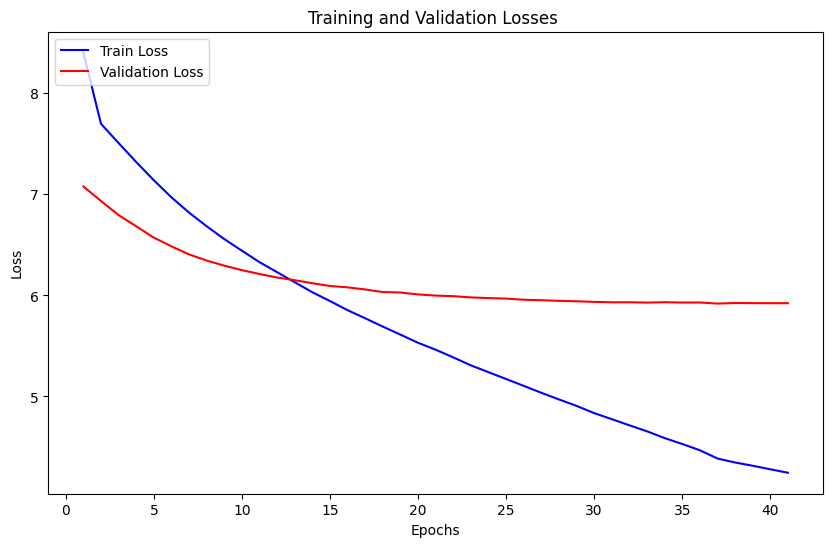

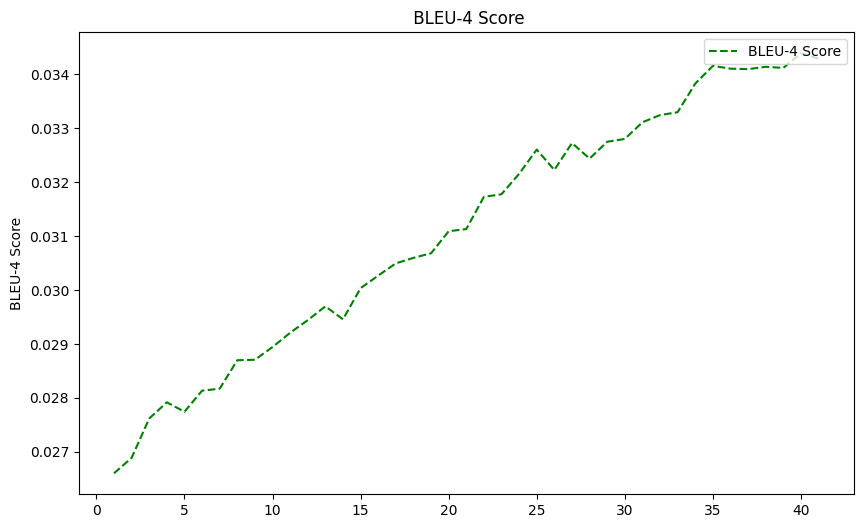

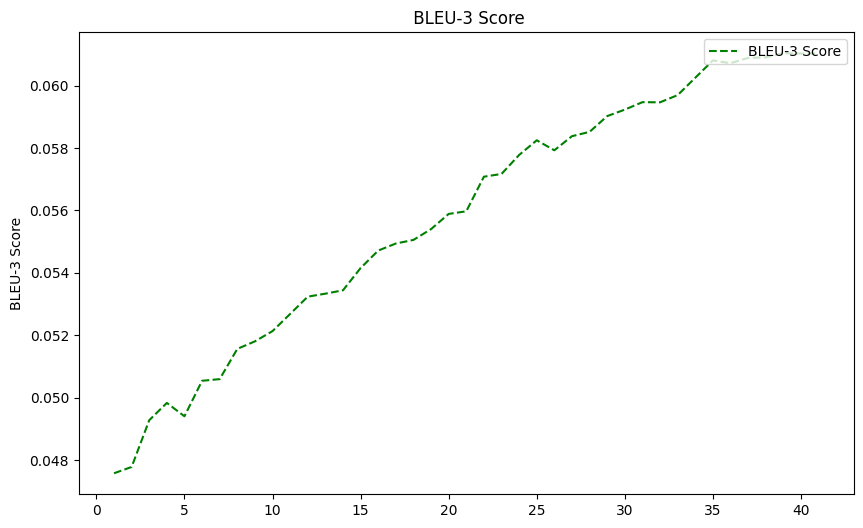

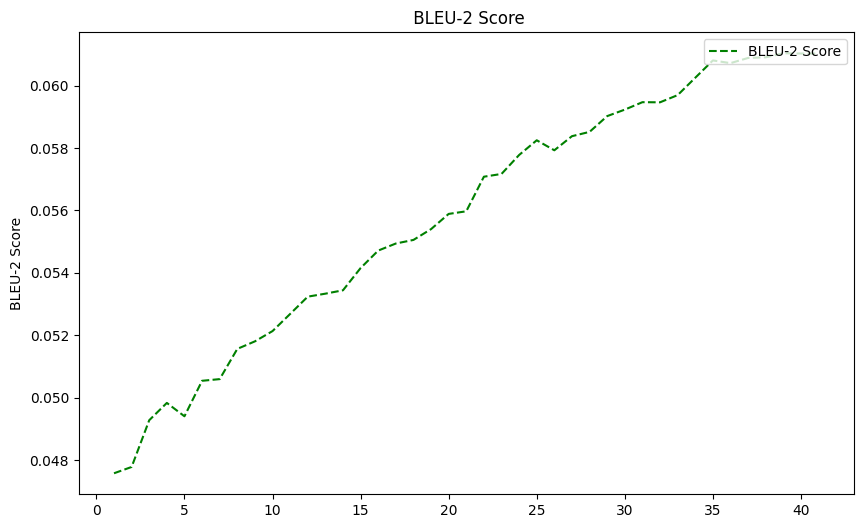

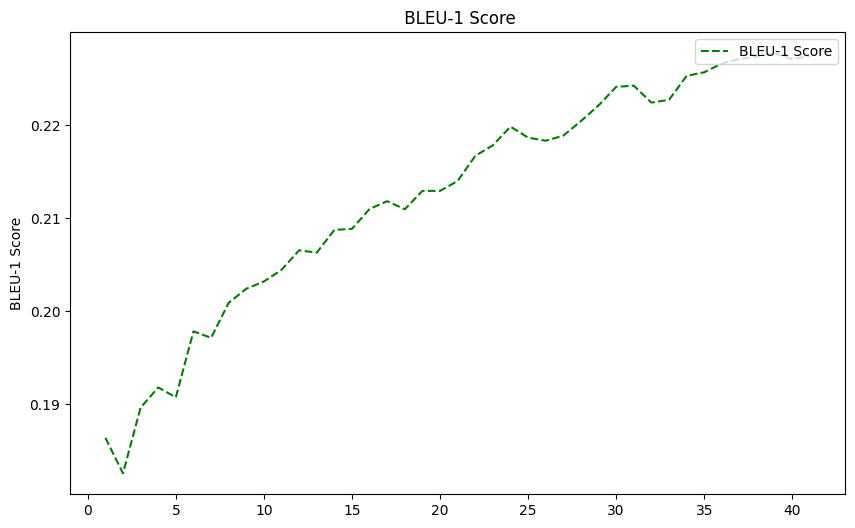

In [30]:
# Plot training metrics
plot_metrics(train_losses, val_losses, bleu_scores)